# Exploratory analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from scipy.signal import periodogram

In [2]:
# import dataset SUD
zone = 'SUD'
PATH = f'data/wind_{zone}.csv'
data = pd.read_csv(PATH)

In [4]:
# convert date to format datetime
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

In [13]:
# complete all the datetimes
all_datetimes = pd.DataFrame(pd.date_range(datetime(df.date.min().year, 1, 1), df.date.max(), freq='d'), columns=["date"])
df = all_datetimes.merge(df, on=['date'], how='outer')
df.set_index('date', inplace=True)
df

,energy
date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,42.5
2015-01-04,50.2
2015-01-05,45.4
...,...
2022-10-22,45.7
2022-10-23,39.6
2022-10-24,46.8


In [14]:
# fill the missing values with the closest available data
df.energy = df.energy.fillna(method='ffill').fillna(method='bfill')

In [26]:
# check if every year has 365 data points (except the last year)
df = df.reset_index(drop=False)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.set_index('date', inplace=True)

count_year_df = df.groupby('year')['energy'].count()
count_year_df

year
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
Name: energy, dtype: int64

In [27]:
# use only complete years
condition = count_year_df >= 365
complete_years = count_year_df.loc[condition].index
df = df.loc[df.year.isin(complete_years)]
df

,energy,year
date,,
2015-01-01,42.5,2015
2015-01-02,42.5,2015
2015-01-03,42.5,2015
2015-01-04,50.2,2015
2015-01-05,45.4,2015
...,...,...
2021-12-27,15.6,2021
2021-12-28,24.3,2021
2021-12-29,3.6,2021


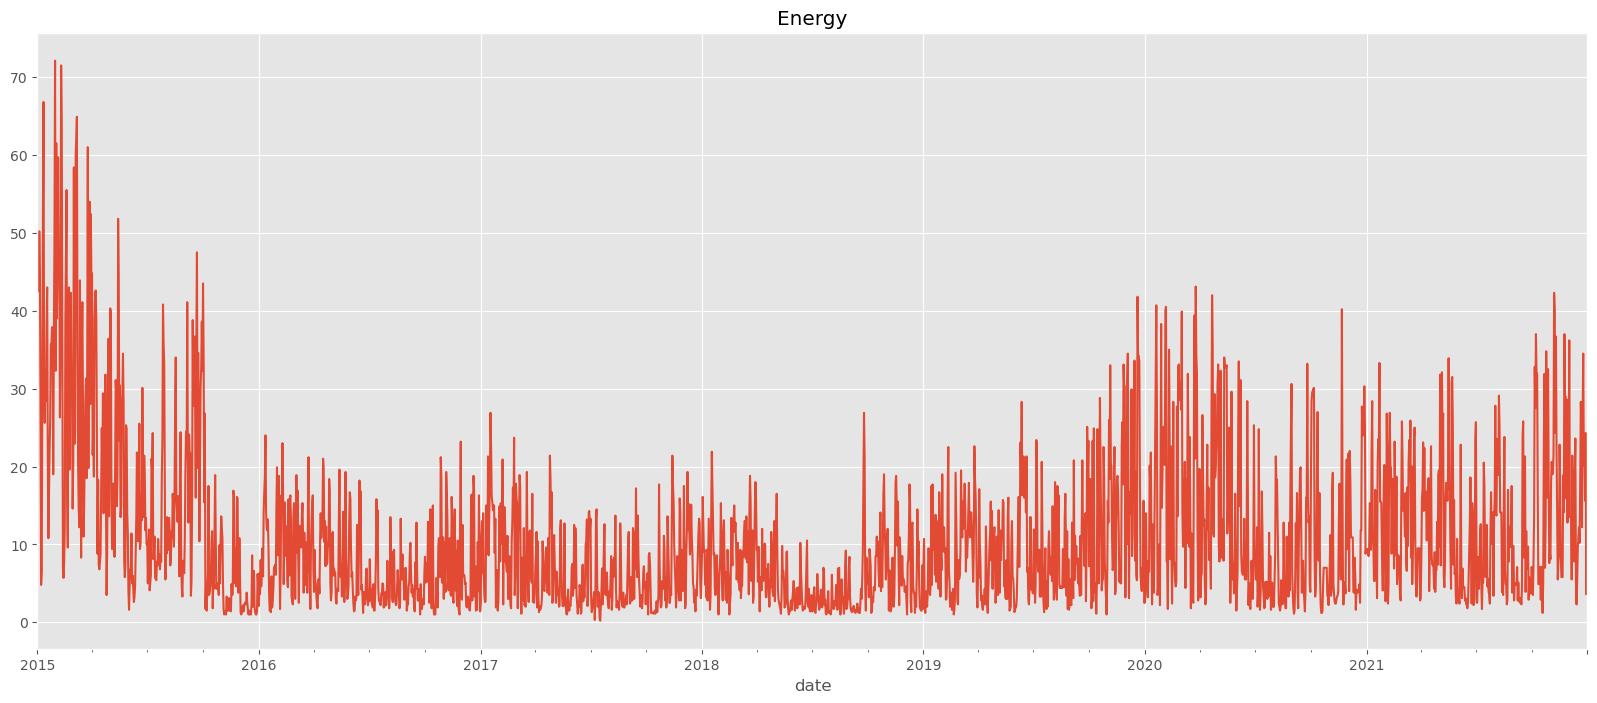

In [31]:
df.energy.plot(figsize=(20,8))
plt.title('Energy')
plt.show()

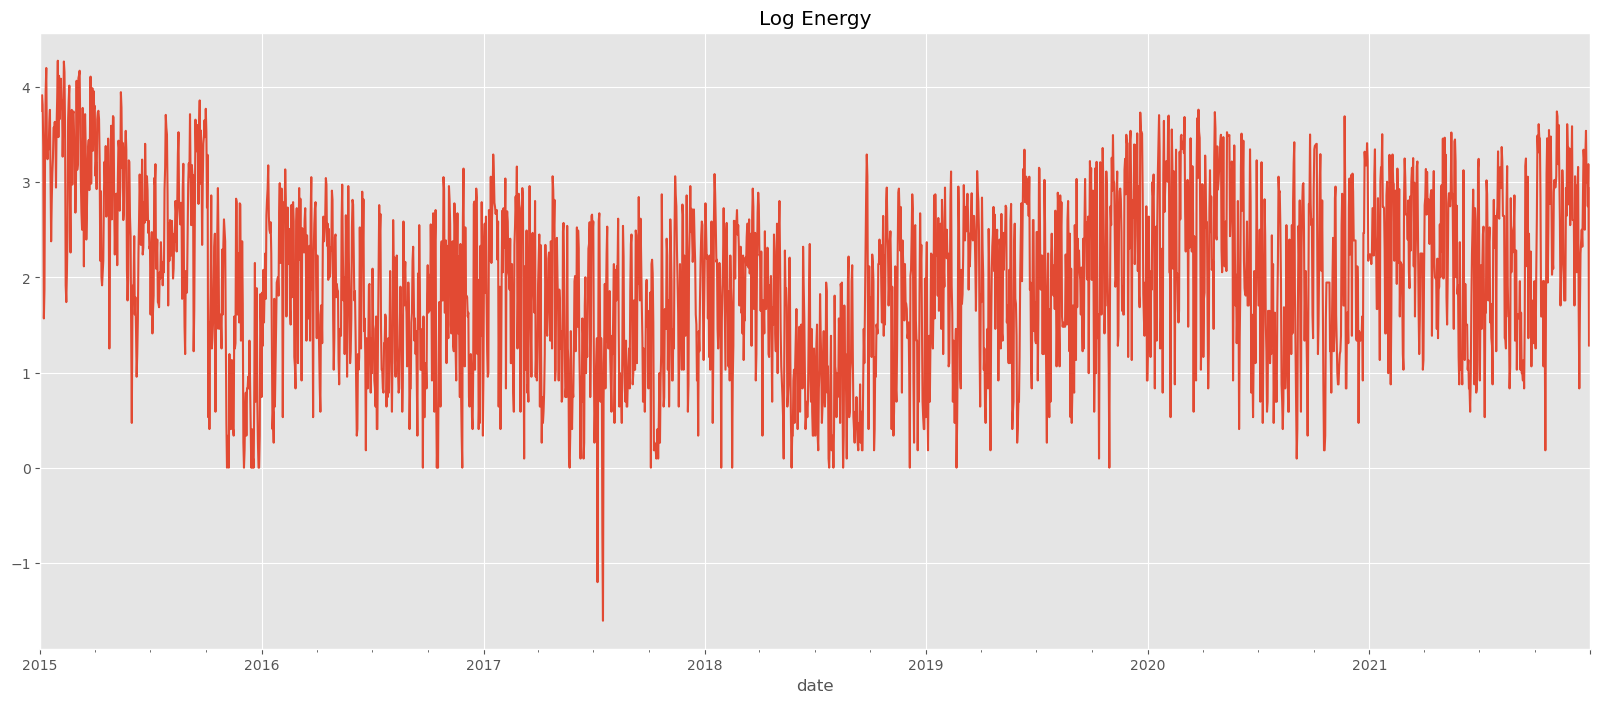

In [32]:
np.log(df.energy).plot(figsize=(20,8))
plt.title('Log Energy')
plt.show()

# Time series decomposition

### Orginal series

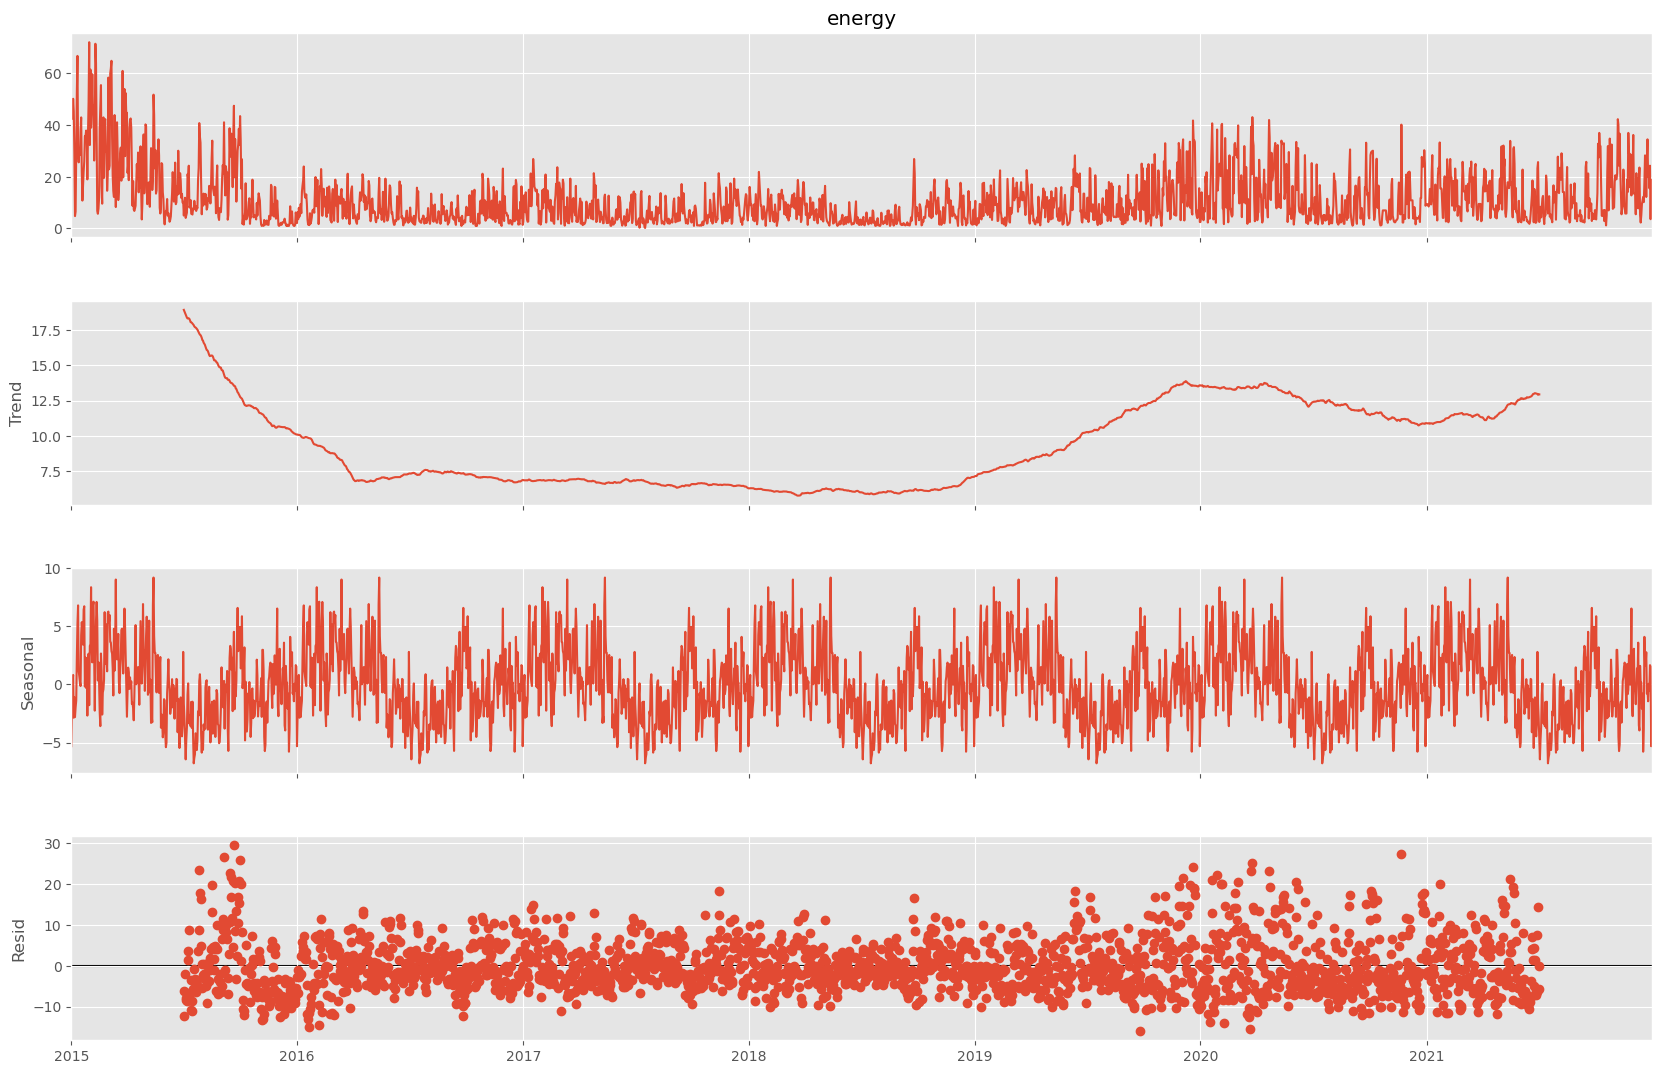

In [33]:
# additive
res = seasonal_decompose(df.energy, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

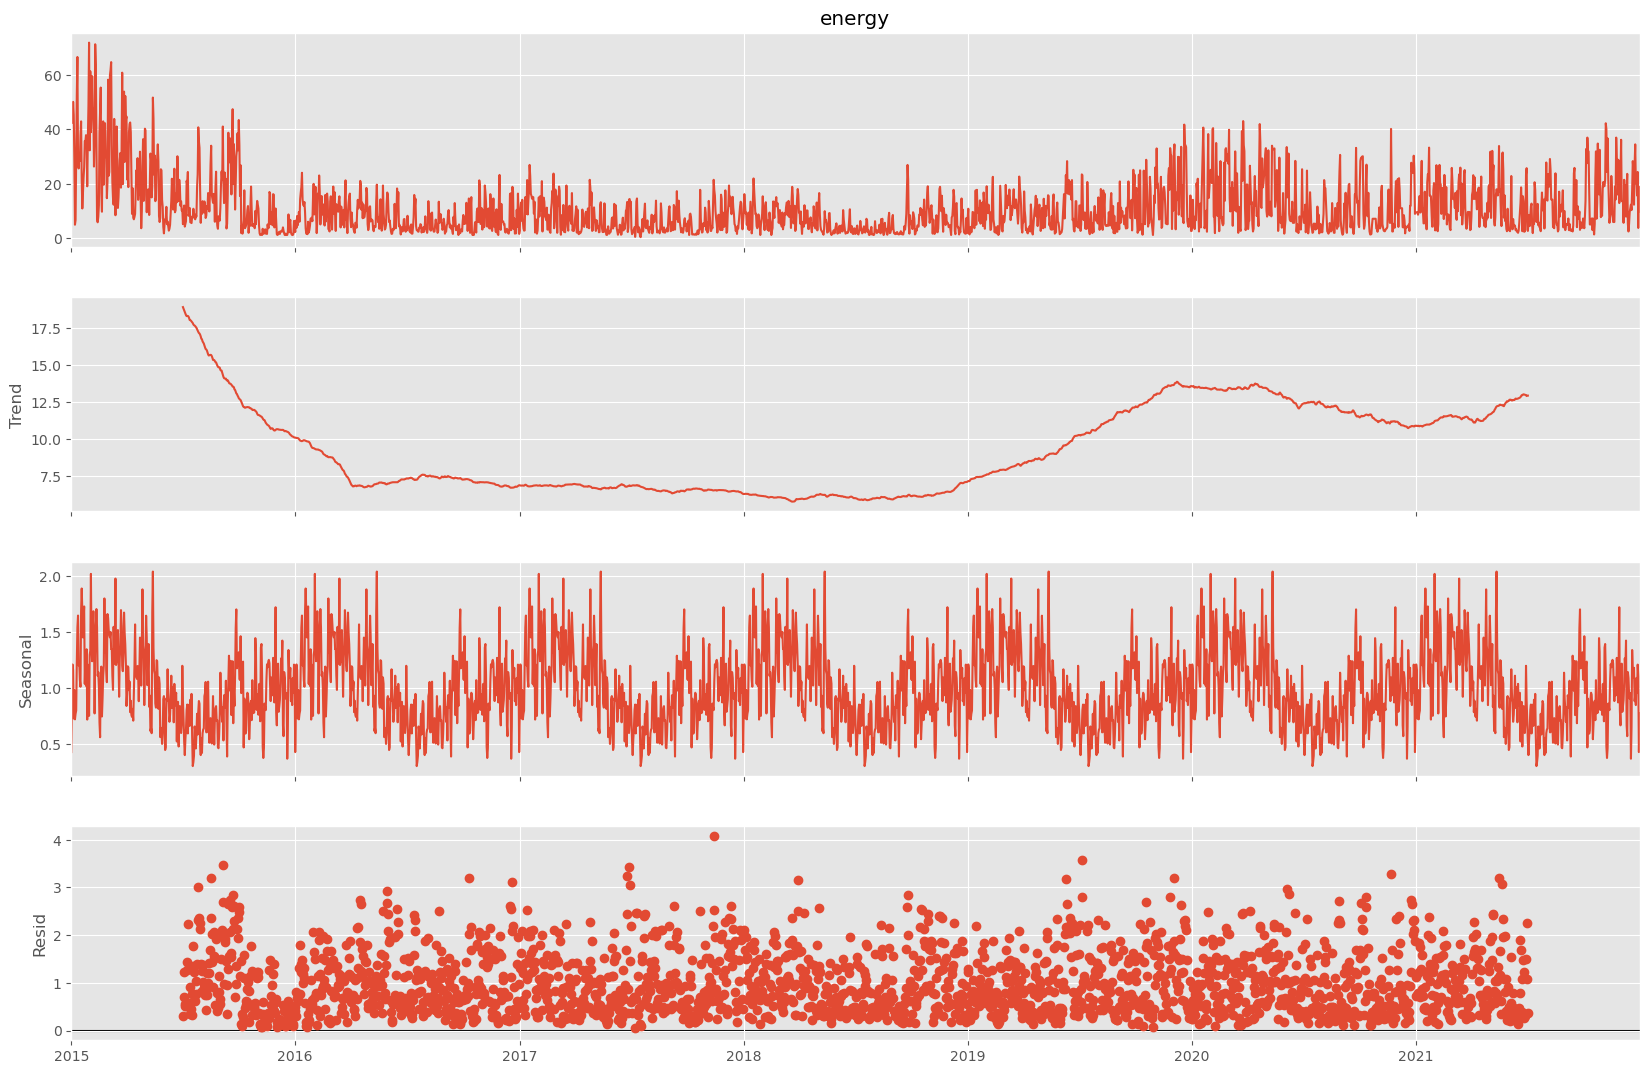

In [13]:
# multiplicative
res = seasonal_decompose(df.energy, model='multiplicative', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

### Log series

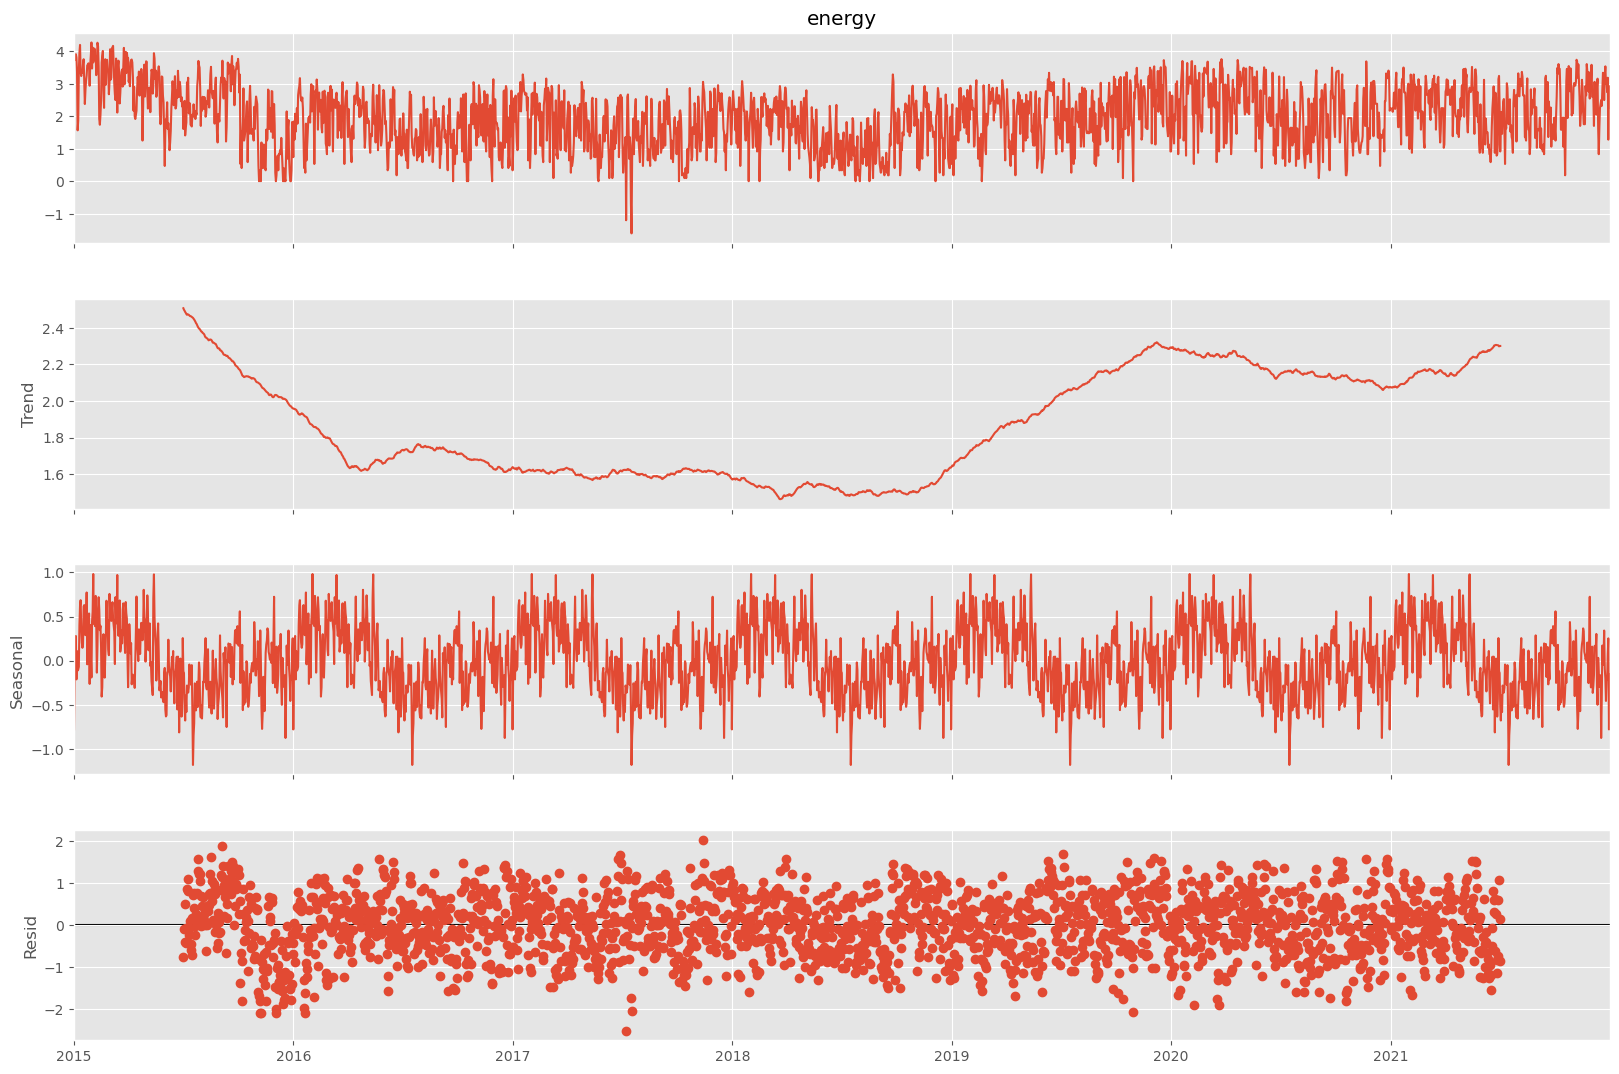

In [36]:
dflog = np.log(df.loc[df.year < 2022, 'energy'])

res = seasonal_decompose(dflog, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

## Trend isolation

We use the log series, with additive decomposition. Let us smooth the trend component.

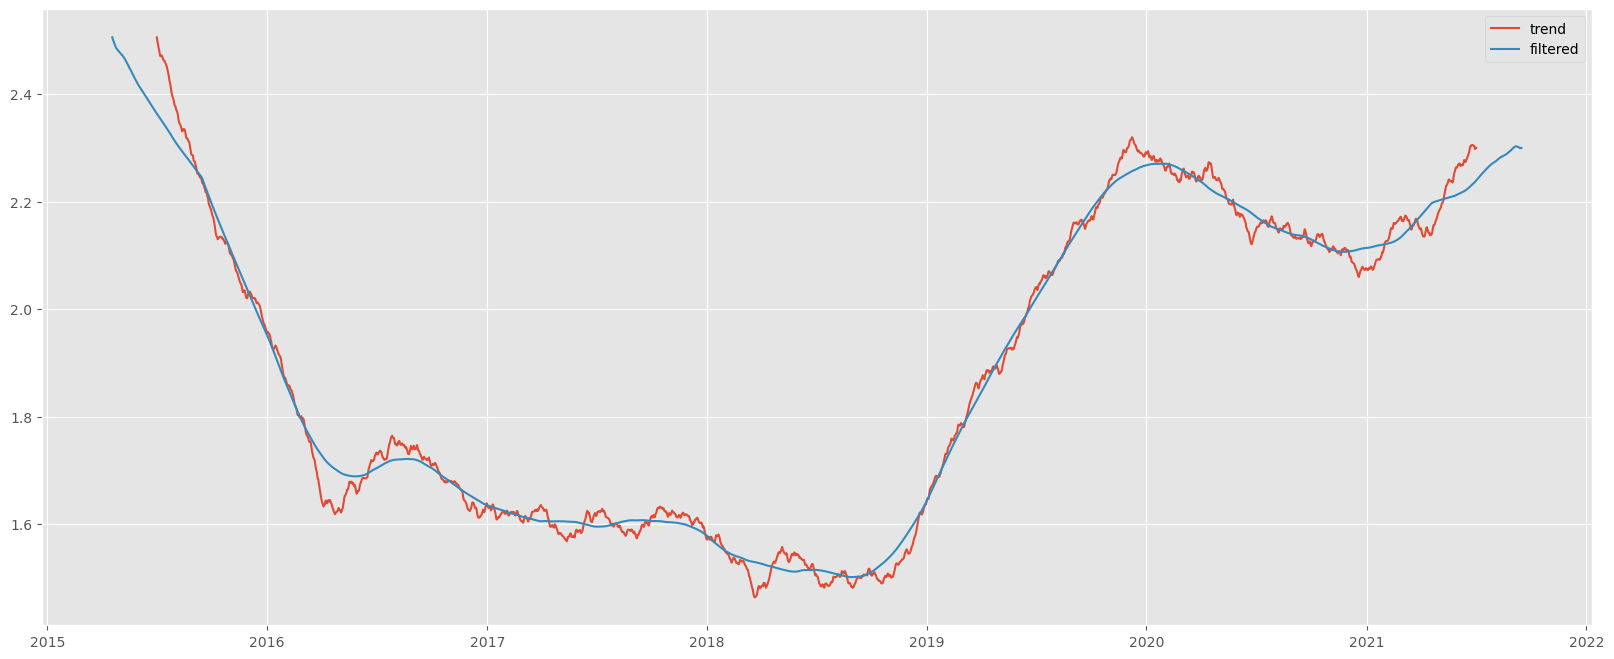

In [37]:
# smooth the trend
x_smooth = res.trend.rolling(150, min_periods=1, center=True).mean()

plt.figure(figsize=(20,8))
plt.plot(res.trend, label='trend')
plt.plot(x_smooth, label='filtered')
plt.legend()
plt.show()

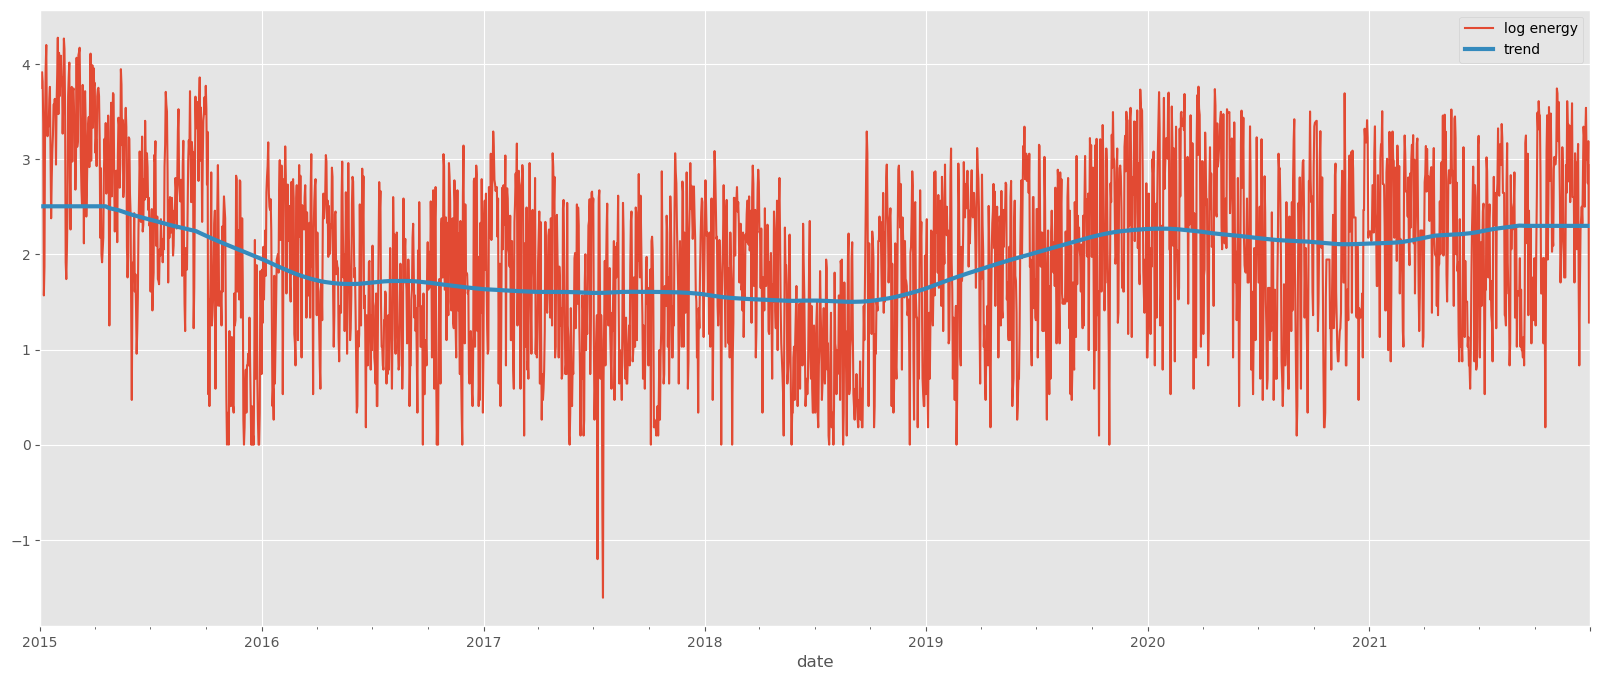

In [48]:
# recover missing data by forward and backward fill
trend = x_smooth
trend = trend.fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(20,8))
dflog.plot(label='log energy')
trend.plot(label='trend', linewidth=3)
plt.legend()
plt.show()

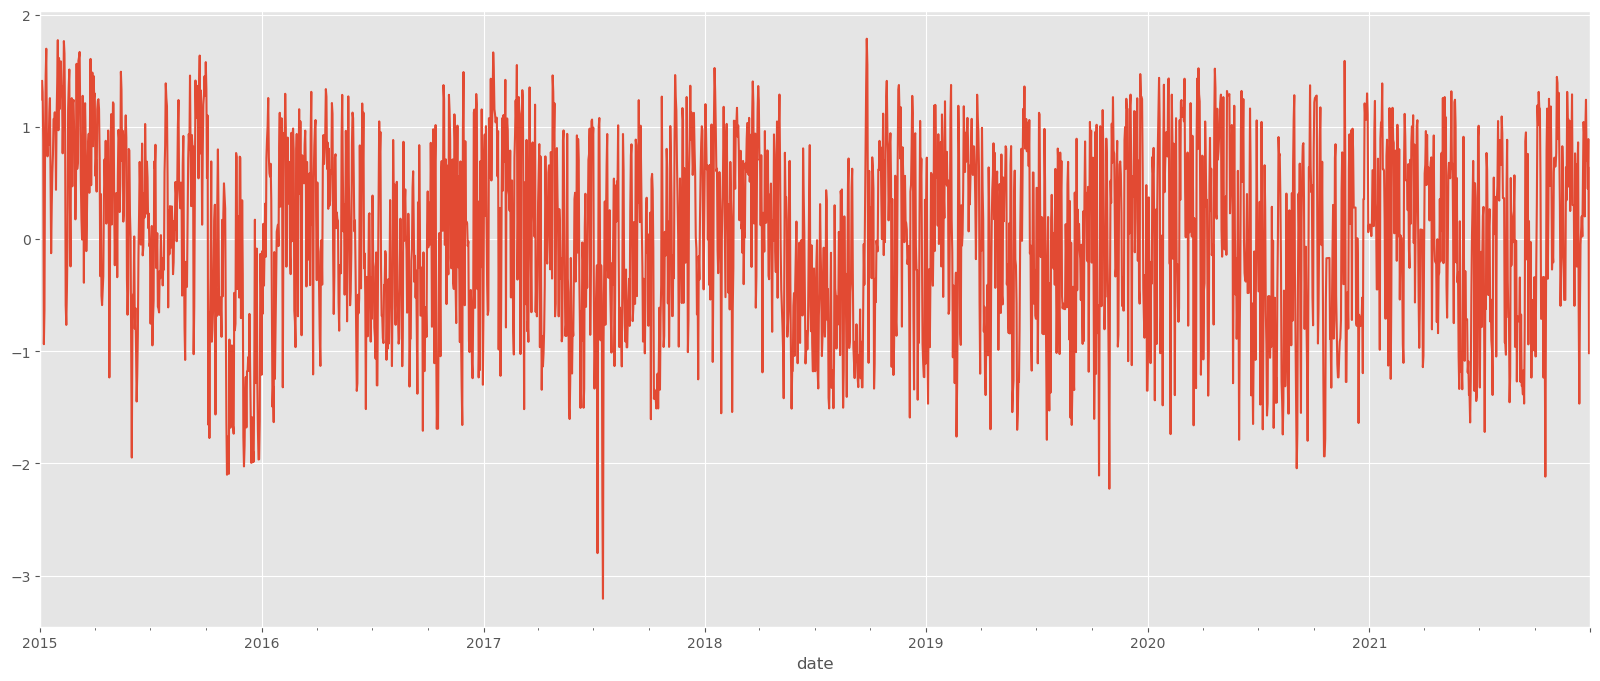

In [47]:
# obtain the detrended series
detrended = dflog - trend
detrended.plot(figsize=(20,8))
plt.show()

## Seasonality isolation

We perform frequency analysis with periodogram.

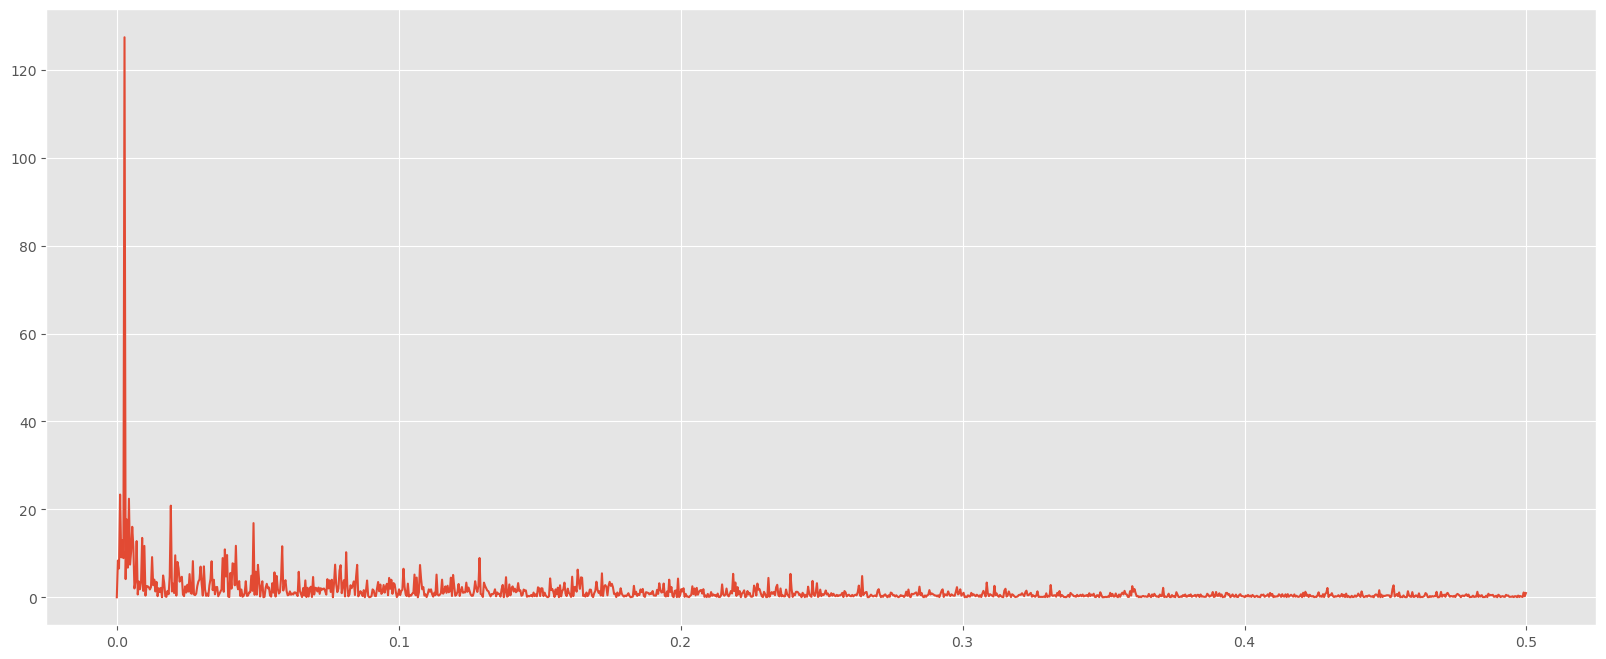

365


In [75]:
# plot periodogram
f, Pxx_den = periodogram(detrended)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

# get the highest frequency
freq = f[Pxx_den > 120]

# which correspond to a certain period
T = int(1/freq)
print(T)

The greatest periodicty is 365 days, as we should have expected.
Now, let remove this periodicity.

In [76]:
# deseasonalize the series
def deseasonalize_fourier(series, period=365):
    """
    Deseasonalize a time series using Fourier decomposition.

    Parameters
    ----------
    series : pandas.Series
        A pandas Series containing the time series data.
    period : int, optional
        The period of the seasonality to be removed. Default is 365.

    Returns
    -------
    pandas.Series
        A pandas Series containing the deseasonalized time series.

    Notes
    -----
    The function performs a Fourier transform to decompose the time series,
    removes the seasonal components, and then applies an inverse Fourier
    transform to reconstruct the deseasonalized time series.
    """
    
    # Perform Fourier Transform
    fft_result = np.fft.rfft(series)
    frequencies = np.fft.rfftfreq(len(series), d=1)

    # Identify frequencies corresponding to the seasonality and set them to zero
    seasonal_freq = 1 / period
    fft_result[np.abs(frequencies - seasonal_freq) < 1e-3] = 0

    # Perform Inverse Fourier Transform
    deseasonalized = np.fft.irfft(fft_result, n=len(series))

    return pd.Series(deseasonalized, index=series.index)

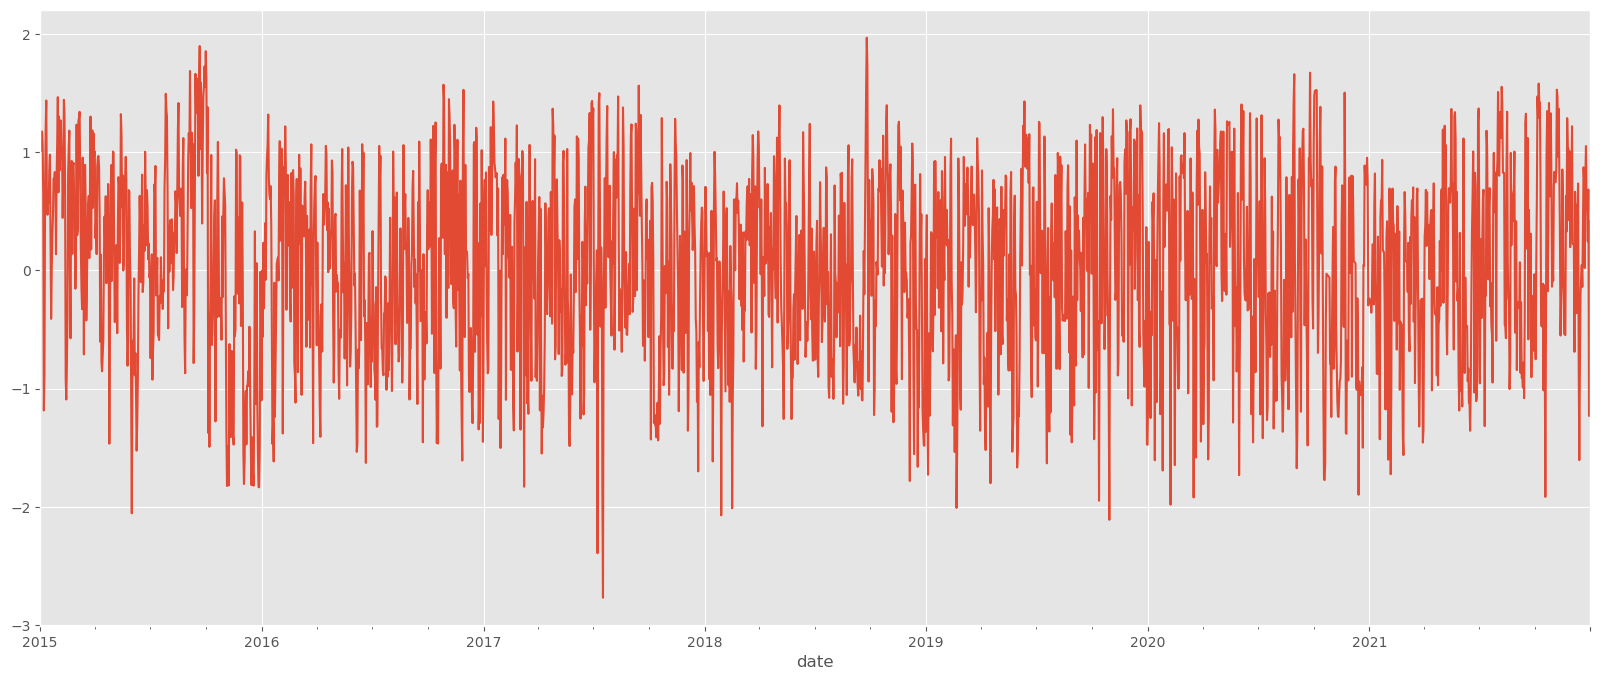

In [77]:
deseasonalized_series = deseasonalize_fourier(detrended, period=T)
deseasonalized_series.plot(figsize=(20,8))
plt.show()

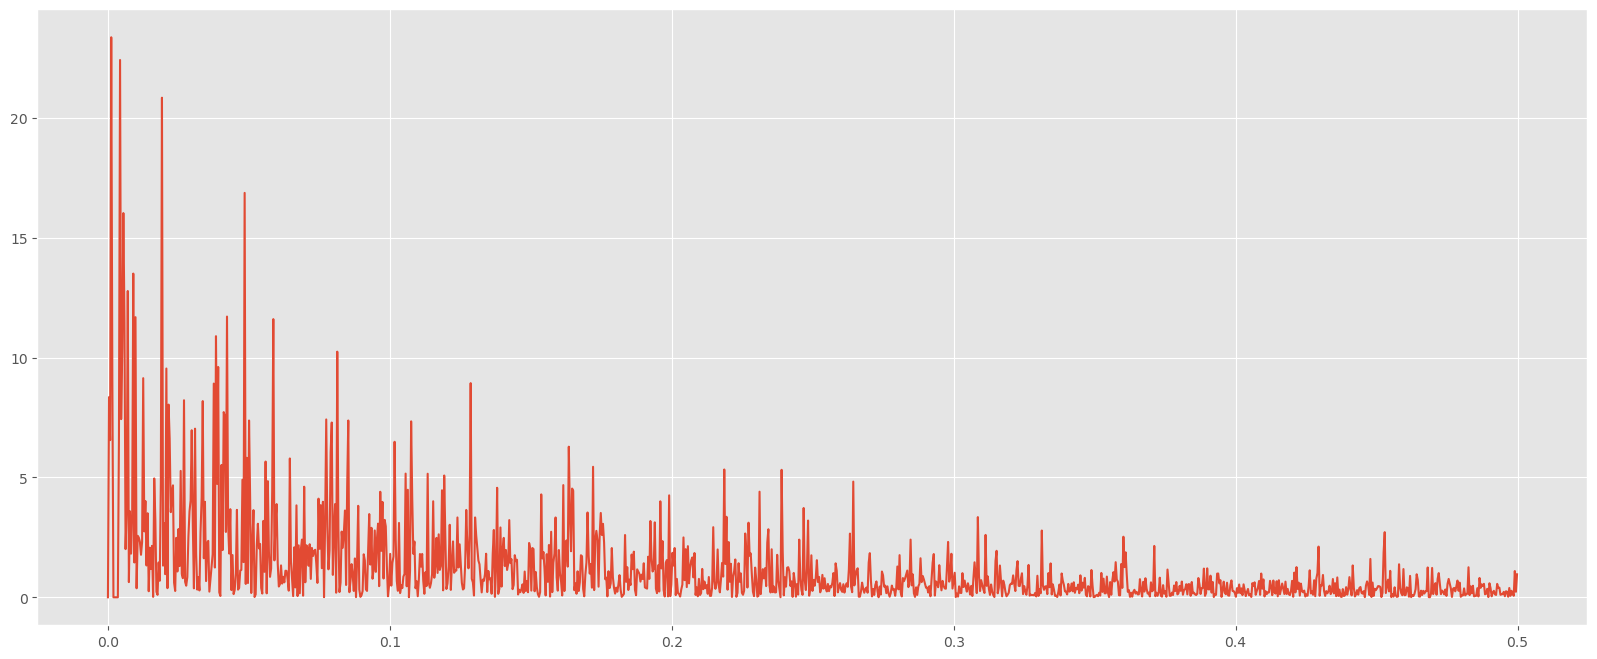

[852, 232, 52]


In [80]:
# check for other periodicities

# plot periodogram
f, Pxx_den = periodogram(deseasonalized_series)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

# get the highest frequency
freq = f[Pxx_den > 20]

# which correspond to a certain period
T = [int(x) for x in 1/freq]
print(T)

No more relevant periodicities

________

## Summary

To recap, the following preprocessing steps have been performed:

* logarithm
* trend isolation
* seasonality isolation

We are left with a stationary time series.

In mathematical terms, let $(Y_t)_t$ be the initial time series.
Now let $(X_t)_t$, where $X_t = \log(Y_t)$.
Time series decomposition leads to 
$$X_t = T_t + S_t + R_t.$$

When we predict new values of the stationary component, say $R_{t+1}$, in order to recover $Y_{t+1}$ we have to revers all the previous steps, i.e. 

* obtain a forecast of the trend: $T_{t+1}$
* obtain a forecast of the seasonal part: $S_{t+1}$; one possibility could be $S_{t+1} = S_{t-T}$, where $T = 365$.
* recover $X_{t+1} = T_{t+1} + S_{t+1} + R_{t+1}$
* finally, $Y_{t+1} = \exp(X_{t+1})$